<a href="https://colab.research.google.com/github/hibana2077/AI-stock-crypto-prediction/blob/main/LSTM_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade pandas

In [2]:
pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [3]:
pip install tensorflow

     |████████████████████████████████| 462 kB 5.4 MB/s 


In [4]:
pip install --upgrade tensorflow

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

INFO:tensorflow:Assets written to: ETH_pre/assets


INFO:tensorflow:Assets written to: ETH_pre/assets


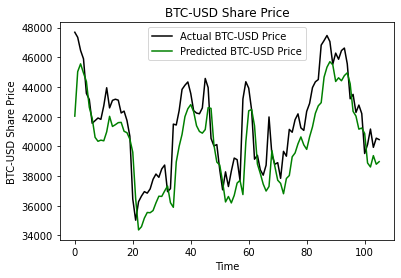

Prediction: [[38992.92]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

#Load Data
company = 'BTC-USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime(2022, 4, 6)

data = web.DataReader(company, 'yahoo', start, end)

#Prepare Data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train=[]
y_train=[]

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Build the Model
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=32)

'''儲存模型'''
model.save('ETH_pre')

'''Test the model accuracy on existing data'''

#Load Test Data
test_start=dt.datetime(2022, 1, 1)
test_end=dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices=test_data['Close'].values

total_dataset=pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make Predictions on Test Data
x_test=[]

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

# Plot the test predictions
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

#Predict Next Day

real_data = [model_inputs[len(model_inputs)  - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction=model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 16 11:25:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
'''讀取模型'''
from tensorflow import keras

model = keras.models.load_model('ETH_pre')

目前有效改善吻合程度的方法有</br>
1.更改訓練次數:<strong>Epoch</strong></br>
2.更改<strong>LSTM</strong>的<strong>unit數量</strong></br>
3.更改<strong>Dropout</strong>的機率 PS:0<=dropout<=1</br>
4.<strong>loss rate</strong>小於0.0015以下會是最好 好像只是用於BTCUSD

<h1>參數紀錄</h1>
<h4><strong>NAME</strong></strong> ==> dropout epoch unit prediction_days<h4>
<h4><strong>BTC-USD</strong> ==> <h4>
<h4><strong>ETH-USD</strong> ==> <h4>